In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from general_functions import create_balanced_dataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
file = open("dataset/zone_7.pickle", "rb")
test_data = pickle.load(file)

In [4]:
#train_data_resampled = create_balanced_dataset(["dataset/zone_4.pickle"])

#with open("dataset/zone_4_resampled.pickle", "wb") as file:
#    pickle.dump(train_data_resampled, file)

with open("dataset/zone_4_resampled.pickle", "rb") as file:
    train_data_resampled = pickle.load(file)

In [5]:
features_to_use = ['impundment_mean_3', 'hpmf_mean_4', 'hpmf_min_2', 'hpmf_median_4', 'impundment_mean_4',
                   'impundment_mean_2', 'hpmf_gabor', 'skyview_gabor', 'DEM_ditch_detection_no_streams',
                   'slope_non_ditch', 'impundment_median_4', 'impundment_median_2', 'impundment_amplified',
                   'skyview_gabor_no_streams', 'hpmf_mean_2', 'hpmf_median_6', 'impoundment_amplified_no_streams',
                   'hpmf_median_2', 'skyview_non_ditch', 'slope_min_2', 'skyview_max_4', 'skyview_max_6', 'hpmf_min_4',
                   'impundment_max_2', 'impundment_std_4']

In [6]:
X_train = np.array(train_data_resampled)[:,1:].astype(np.float32)
X_train = StandardScaler().fit_transform(X_train).astype(np.float32)
y_train = np.array(train_data_resampled)[:, 0].astype(np.int64)

In [7]:
X_train.shape

(317175, 81)

In [8]:
class EncoderDataset(Dataset):
    def __init__(self, X, y):
        self.data = X[:]
        self.labels = y[:]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx]), self.labels[idx]

batch_size = 128
dataloader = DataLoader(EncoderDataset(X_train, y_train), batch_size = batch_size, shuffle=True, drop_last=True)

In [9]:
class Net(nn.Module):
    def __init__(self, inputs):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(inputs, 64),
            
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )
        
    def forward(self, x):
        return self.net(x)
    
net = Net(81).to(device)

In [10]:
net

Net(
  (net): Sequential(
    (0): Linear(in_features=81, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=256, out_features=512, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=256, out_features=128, bias=True)
    (16): ReLU()
    (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, a

In [11]:
epoch_size = int(len(dataloader.dataset) / batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0005, max_lr=0.01, cycle_momentum=False,
                                             step_size_up= epoch_size * 3, step_size_down=epoch_size * 1)

In [12]:
net.train()
losses = []
for epoch in range(200):
    running_loss = 0.0
    for i, (features, labels) in enumerate(dataloader):
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        preds = net(features)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        if i % 300 == 299:    # print every 2000 mini-batches\n",
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            losses.append(running_loss / 299)
            running_loss = 0.0

[1,   300] loss: 0.061
[1,   600] loss: 0.057
[1,   900] loss: 0.057
[1,  1200] loss: 0.056
[1,  1500] loss: 0.056
[1,  1800] loss: 0.055
[1,  2100] loss: 0.055
[1,  2400] loss: 0.055
[2,   300] loss: 0.055
[2,   600] loss: 0.054
[2,   900] loss: 0.054
[2,  1200] loss: 0.055
[2,  1500] loss: 0.055
[2,  1800] loss: 0.054
[2,  2100] loss: 0.054
[2,  2400] loss: 0.054
[3,   300] loss: 0.054
[3,   600] loss: 0.053
[3,   900] loss: 0.054
[3,  1200] loss: 0.054
[3,  1500] loss: 0.054
[3,  1800] loss: 0.054
[3,  2100] loss: 0.054
[3,  2400] loss: 0.054
[4,   300] loss: 0.054
[4,   600] loss: 0.053
[4,   900] loss: 0.052
[4,  1200] loss: 0.053


KeyboardInterrupt: 

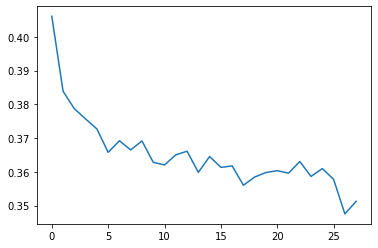

In [13]:
plt.plot([i for i in range(len(losses))], losses)

In [14]:
with torch.no_grad():
        acc = .0
        net.eval()
        for i, (features, labels) in enumerate(dataloader):
            features = features.to(device)
            #features = (features - features.mean()) / features.std()
            labels = labels.to(device)

            preds = net(features)
            preds = F.softmax(preds, dim=1)
            p = preds.argmax(dim=1)
            acc += (p==labels).sum().item() / preds.shape[0]
            
        print((acc/(i+1)))
net.train()
print()

0.8396434699232943



In [109]:
input.dtype

torch.float32

In [110]:
target.dtype

torch.float32